In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.tseries_model.tseries_model_qa import make_design_qa_figure

# What is this?

This notebook performs quality assurance (QA) on the design matrices prior to model estimation.

### Incomplete BOLD Runs

Many subjects’ BOLD runs did not extend long enough to capture the final trial(s).

To avoid singular or ill-conditioned design matrices:

* I check whether any trial onset times occur after the final acquired frame.

* If only one trial occurs beyond the last frame, that trial is omitted.

* If multiple trials occur beyond the last frame, the design matrix for that run is not generated.

### Variance Inflation Factors (VIFs)

Variance inflation factors were estimated for:

* The beta-series regressors

* The accept-minus-reject contrast

Observations:

* VIFs are generally excellent (most < 5).

* Beta estimates will be further monitored for outlier runs after model estimation.

### Runs Excluded from Design Generation

Design matrices will not be generated for:

* sub=dmp0063, run=2 — ❌ 17 trials are clipped beyond the final frame.

In [2]:
cfg = load_config()
good_subs_csv = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_csv)

In [3]:
out_pdf = Path('./figures/design_matrix_assessment.pdf')
out_pdf.parent.mkdir(parents=True, exist_ok=True)

vif_all = []

with PdfPages(out_pdf) as pdf:
    for row in good_subs.itertuples(index=False):
        sub_id = row.sub_id
        run = row.run
        print(f'Processing sub={sub_id}, run={run}...')
        fig = None
        try:
            fig, vifs = make_design_qa_figure(cfg, sub_id, run)
            pdf.savefig(fig, bbox_inches='tight')
            vifs['sub_id'] = sub_id
            vifs['run'] = run
            vif_all.append(vifs)
        except Exception as e:
            print(f'⚠️ Error for sub={sub_id}, run={run}: {e}')
        finally:
            if fig is not None:
                plt.close(fig)


Processing sub=dmp0011, run=1...
❌ 1 trial for sub dmp0011, run 1 are clipped. Removing the trial and continuing.
Processing sub=dmp0011, run=2...
❌ 1 trial for sub dmp0011, run 2 are clipped. Removing the trial and continuing.
Processing sub=dmp0011, run=3...
❌ 1 trial for sub dmp0011, run 3 are clipped. Removing the trial and continuing.
Processing sub=dmp0011, run=4...
❌ 1 trial for sub dmp0011, run 4 are clipped. Removing the trial and continuing.
Processing sub=dmp0019, run=1...
❌ 1 trial for sub dmp0019, run 1 are clipped. Removing the trial and continuing.
Processing sub=dmp0019, run=2...
❌ 1 trial for sub dmp0019, run 2 are clipped. Removing the trial and continuing.
Processing sub=dmp0019, run=3...
❌ 1 trial for sub dmp0019, run 3 are clipped. Removing the trial and continuing.
Processing sub=dmp0019, run=4...
❌ 1 trial for sub dmp0019, run 4 are clipped. Removing the trial and continuing.
Processing sub=dmp0048, run=1...
Processing sub=dmp0048, run=2...
❌ 1 trial for sub dmp0

## VIFs generally look great

In [4]:
vif_all_df = pd.concat(vif_all)


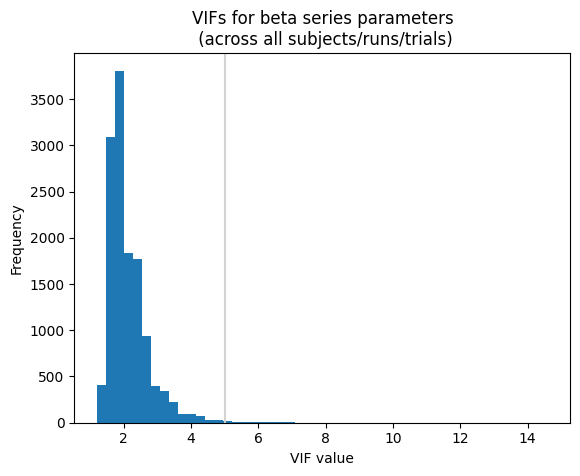

In [5]:
trial_cols = [col for col in vif_all_df.columns if col.startswith('trial')]

# Extract values, flatten, and drop NaNs
trial_values = vif_all_df[trial_cols].values.ravel()
trial_values = trial_values[~np.isnan(trial_values)]

# Plot histogram
plt.figure()
plt.hist(trial_values, bins=50)
plt.axvline(x=5, color='lightgray')
plt.xlabel('VIF value')
plt.ylabel('Frequency')
plt.title('VIFs for beta series parameters\n (across all subjects/runs/trials)')
plt.show()

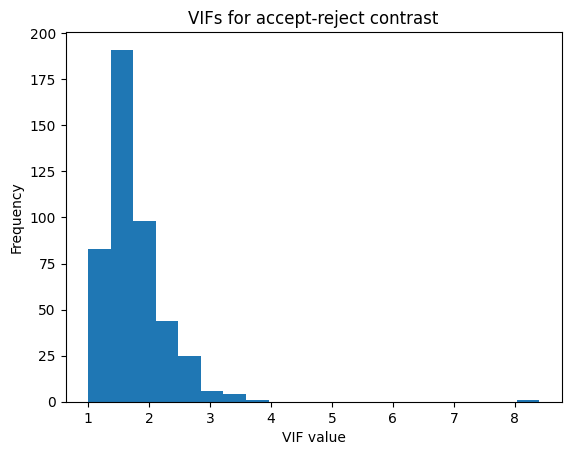

In [6]:
plt.hist(vif_all_df['accept_minus_reject'], 20)
plt.xlabel('VIF value')
plt.ylabel('Frequency')
plt.title('VIFs for accept-reject contrast')
plt.show()